# `20180812a` - Checking Kretz probe - servo - server

In [2]:
#!/usr/bin/python
import spidev
#import RPi.GPIO as GPIO
import time
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import time
from pyUn0 import *
%matplotlib inline

## Now inline viz can be done

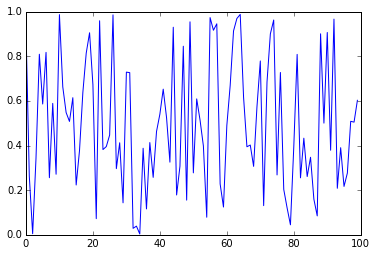

In [17]:
plt.plot(np.random.sample(100));
plt.show()

In [2]:
x = us_spi()
x.JSON = {}
x.JSON["firmware_md5"]="fa6a7560ade6d6b1149b6e78e0de051f"
x.JSON["firmware_version"]="e_un0"
x.JSON["data"]=[]
x.JSON["registers"]={}
x.JSON["experiment"]={}
x.JSON["parameters"]={}
x.JSON["experiment"]["id"] = "20180812a"
x.JSON["experiment"]["description"]="Testing the kretz probe"
x.JSON["experiment"]["probe"]="kretz"
x.JSON["experiment"]["target"] = "pu in bottom of water mug"
x.JSON["experiment"]["position"] = "na"
x.JSON["V"]="48"

In [3]:
x.StartUp()
x.ConfigSPI()

# Setting acquition speed
f = 7 # That's for 8Msps
x.WriteFPGA(0xED,f) # Frequency of ADC acquisition / sEEADC_freq (3 = 16Msps, 1 = 32, 0 = 64, 2 = 21Msps)

x.WriteFPGA(0xEB,1) # Doing one line if 0, several if 1

NLines = 800

x.WriteFPGA(0xEC,NLines) # Doing 700 lines

Fech = int(64/((1+f)))


pyUn0.py:101: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(CS_FLASH,GPIO.OUT)


Reset GPIO 23 - Low 1s
Reset GPIO 23 - High 0.2s
spi.cshigh is False
spi mode is 1
spi maxspeed is 2000000hz
Pulse width: 200  ns --  0x14
Pulses delay: 100  ns --  0xa
Poff: 2000  ns --  0x0 0xc8
Delay between: 7000 ns --  0x2 0xbc
Config FPGA done!


In [4]:
x.JSON["N"] = 10 # Experiment ID

In [11]:
NLines = 300
x.WriteFPGA(0xEC,NLines) # Doing 800 lines
f = 2
x.WriteFPGA(0xED,f) # Frequency of ADC acquisition / sEEADC_freq (3 = 16Msps, 1 = 32, 0 = 64, 2 = 21Msps)
Fech = int(64/((1+f)))

In [13]:
# Timings
WaitTill = 13000
t1 = 200
t2 = 100
t3 = 2000
t4 = WaitTill-t1-t2-t3 # 20us delay before acquisition
t5 = 85000 # 80us acquisition

x.setPeriodAcq(1000*1000) #1000 us delays

LAcq = (t5-WaitTill)/1000 #ns to us 

Nacq = LAcq * Fech * NLines
print LAcq,Nacq
# Setting up the DAC, from 50mV to 850mv
Curve = x.CreateDACCurve(300,800,True)[0]
x.setDACCurve(Curve)
# Setting pulses
x.setPulseTrain(t1,t2,t3,t4,t5)

Period between two acquisitions: 100000 us -- 0x1 0x86 0xa0
72 453600
Pulse width: 200  ns --  0x14
Pulses delay: 300  ns --  0x1e
Poff: 2500  ns --  0x0 0xfa
Delay between: 13700 ns --  0x5 0x5a
Acquisition length:  101700  us --  0x27 0xba


101700

In [15]:
x.JSON["N"] = x.JSON["N"] +1
x.JSON["experiment"]["target"] = "Wirephantom"
# Trigger
x.WriteFPGA(0xEF,0x01) # Cleaning memory pointer
x.WriteFPGA(0xEA,0x01) # Software Trig : As to be clear by software

A = []

milestone = Nacq / 5

start = time.time()
for i in range(2*Nacq+1):
    A.append ( x.spi.xfer([0x00] )[0] )
    if not (i%milestone):
        print str((50*i)/Nacq)+"%"
end = time.time()
delta = end - start
print "Took %.2f seconds to transfer." % delta 
print "for "+str(2*Nacq+1)+" transfers of data"

a = np.asarray(A).astype(np.int16)


x.JSON["data"] = A

with open(x.JSON["experiment"]["id"]+"-"+str(x.JSON["N"])+".json", 'w') as outfile:
    json.dump(x.JSON, outfile)
    
print x.JSON["experiment"]["id"]+"-"+str(x.JSON["N"])+".json:  DONE"

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Took 96.62 seconds to transfer.
for 907201 transfers of data
20180812a-12.json:  DONE
